---
title: "Neutron Reproduction Factors"
author: "Johann van Rooyen"
date: today
format:
  pdf:
    # --- Rendering engine ---
    # Use 'lualatex' for full LaTeX compatibility, or 'typst' for speed.
    pdf-engine: typst    # lualatex

    # --- Fonts (Unicode + Math) ---
    mainfont: "DejaVu Serif"
    sansfont: "DejaVu Sans"
    monofont: "DejaVu Sans Mono"
    mathfont: "Latin Modern Math"

    # --- Page layout ---
    fontsize: 10pt
    linestretch: 1.25
    geometry:
      - top=20mm
      - bottom=20mm
      - left=20mm
      - right=20mm
    papersize: a3

    # --- Document features ---
    toc: true
    toc-depth: 3
    number-sections: true
    highlight-style: tango
    code-block-bg: "#f8f9fa"
    code-block-border-left: "#007ACC"
    code-line-numbers: true

    # --- Captions, tables, and figures ---
    fig-pos: "H"
    fig-align: center
    fig-cap-location: bottom
    tbl-cap-location: top

    # --- PDF metadata ---
    include-in-header:
      text: |
        % Nuclear Engineering / Reactor Physics Report Settings
        \usepackage{siunitx}    % for physical units
        \usepackage{booktabs}   % for professional tables
        \usepackage{mhchem}     % for isotopes (e.g., \ce{U-235})
        \usepackage{physics}    % for \dv, \pdv, \qty
        \usepackage{microtype}  % better typography
        \setlength{\parskip}{6pt}
        \setlength{\parindent}{0pt}

---

# Neutron reproduction factors of selected nuclear fuels, using JEFF-4.0 (2025) nuclear data

#### The neutron reproduction factor $\eta$ figures in heuristic 4-factor and 6-factor formulae of the concept ***neutron multiplication factor*** and is also used in the preliminary evaluation of the viability of a nuclear fuel type for use in a breeder reactor, or in a reactor with a high conversion rate.  If the fluence-weighted neutron reproduction factor $$\displaystyle \langle \eta \rangle = \frac{\displaystyle \int_{0}^{\infty}\eta\left(E\right)\varphi_{n}\left(E\right)\;dE} {\displaystyle \int_{0}^{\infty}\varphi_{n}\left(E\right)\; dE}$$ is substantially larger than 2, the nuclear fuel can in principle breed.
<p>&nbsp;</p>

#### The neutron reproduction factor $\displaystyle\eta$ for pure $\displaystyle _{\;92}^{233}\text{U}$ nuclear fuel is  $$\displaystyle\eta = \displaystyle \frac{\nu\left(_{\;92}^{233}\text{U}\right) \times \sigma_{\left(n,f\right)}\left(_{\;92}^{233}\text{U}\right)}{\sigma_{\left(n,f\right)}\left(_{\;92}^{233}\text{U}\right) + \sigma_{\left(n,\gamma\right)}\left(_{\;92}^{233}\text{U}\right)}.$$

<p>&nbsp;</p>

#### The neutron reproduction factor $\displaystyle\eta$ for pure $\displaystyle _{\;92}^{235}\text{U}$ nuclear fuel is  $$\displaystyle\eta = \displaystyle \frac{\nu\left(_{\;92}^{235}\text{U}\right) \times \sigma_{\left(n,f\right)}\left(_{\;92}^{235}\text{U}\right)}{\sigma_{\left(n,f\right)}\left(_{\;92}^{235}\text{U}\right) + \sigma_{\left(n,\gamma\right)}\left(_{\;92}^{235}\text{U}\right)}.$$

<p>&nbsp;</p>

#### The neutron reproduction factor $\displaystyle\eta$ for pure $\displaystyle _{\;94}^{239}\text{Pu}$ nuclear fuel is  $$\displaystyle\eta = \displaystyle \frac{\nu\left(_{\;94}^{239}\text{Pu}\right) \times \sigma_{\left(n,f\right)}\left(_{\;94}^{239}\text{Pu}\right)}{\sigma_{\left(n,f\right)}\left(_{\;94}^{239}\text{Pu}\right) + \sigma_{\left(n,\gamma\right)}\left(_{\;94}^{239}\text{Pu}\right)}.$$

<p>&nbsp;</p>

#### The neutron reproduction factor $\displaystyle\eta$ expresses the number of (fast) fission neutrons emitted per 1 neutron absorbed in the nuclear fuel, in fission as well as capture reactions.

<p>&nbsp;</p>

(In terminal: python -m jupyter labextension enable jupyterlab-quarto)

## Import Python packages and make some settings

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy
from   scipy.interpolate import PchipInterpolator
from   scipy.integrate import quad

import warnings
warnings.filterwarnings('ignore')

import pint
from pint import UnitRegistry
u = pint.UnitRegistry()
u.setup_matplotlib(True)
Q_ = u.Quantity

# MatPlotLib settings:
%matplotlib inline
%config InlineBackend.figure_format='svg'

In [2]:
# Set default parameters:
plt.rc('lines',  linewidth=5)
plt.rc('figure', figsize=(12,9))
plt.rc('axes',   titlesize=30)
plt.rc('axes',   labelsize=26)
plt.rc('legend', fontsize=20)
plt.rc('xtick',  labelsize=22)
plt.rc('ytick',  labelsize=22)
plt.rc('lines',  markersize=14)

plt.rcParams['figure.constrained_layout.use'] = True
mpl.rcParams['font.family'] = ['Aptos', 'sans-serif']
mpl.rcParams['mathtext.fontset'] = 'dejavuserif'
mpl.rcParams['mathtext.rm'] = 'Aptos'
mpl.rcParams['mathtext.it'] = 'Aptos:italic'
mpl.rcParams['mathtext.bf'] = 'Aptos:bold'

labelpad_x        = 12
labelpad_y        = 8
position_title_y  = 1.025

# Line widths:
lw_grid_major = 1.25
lw_grid_minor = 0.75
#
lw_hlines = 2.0
lw_vlines = 2.0

# Colours:
color_grid_major  =  'xkcd:charcoal'
color_grid_minor  =  'xkcd:grey'

color_hlines      =  'xkcd:Cherry'
color_vlines      =  'xkcd:Rouge'

In [ ]:
# Paths for i/o:
path_cwd_abs         =  os.getcwd()
#
path_xs_inp_rel      =  r'data/xs_nf_ng/'          # Neutron-induced fission and neutron capture cross-sections
path_yfn_inp_rel     =  r'data/yield_fn/'          # Yield of fission neutrons
path_nspec_inp_rel   =  r'data/NeutronSpectra/'    # Neutron spectra for various fission reactors
path_graphs_out_rel  =  r'GraphBank/'              # Output graphs
#
path_xs_inp_abs      =  os.path.join(path_cwd_abs, path_xs_inp_rel)
path_nspec_inp_abs   =  os.path.join(path_cwd_abs, path_nspec_inp_rel)
path_yfn_inp_abs     =  os.path.join(path_cwd_abs, path_yfn_inp_rel)
path_graphs_out_abs  =  os.path.join(path_cwd_abs, path_graphs_out_rel)

# Data source files:
spreadsheet_xs_nf    =  path_xs_inp_abs    +  'xs_nf_actinides.xlsx'
spreadsheet_xs_nγ    =  path_xs_inp_abs    +  'xs_ng_actinides.xlsx'
spreadsheet_nspec    =  path_nspec_inp_abs +  'neutron_spectrum_fission_reactors.xlsx'
spreadsheet_yfn      =  path_yfn_inp_abs   +  'yield_fission_neutrons.xlsx'

#### Set consistent linestyles and linewidths

In [4]:
# LineStyles
# High
ls1 = 'solid'
lw1 = 5
# Medium
ls2 = (0, (3, 1, 3, 1))
lw2 = 4
# Low
ls3 = (0, (2, 1, 1, 1))
lw3 = 3

lw_grid_major = 1.00
lw_grid_minor = 0.75

#### Set a consistent colour scheme for graphs

In [5]:
# Set consistent colour scheme:

color_n = 'xkcd:grassy green'

color_vlines      =  'xkcd:Rouge'
color_grid_major  =  'xkcd:Charcoal'
color_grid_minor  =  'xkcd:Grey'
color_vspans      =  'xkcd:Pale Green'

color_u232        =  'xkcd:cerise'
color_u233        =  'xkcd:electric blue'
color_u234        =  'xkcd:dark cyan'
color_u235        =  'xkcd:violet blue'
color_u236        =  'xkcd:ultramarine'
color_u238        =  'xkcd:sapphire'
color_pu239       =  'xkcd:rouge'
color_pu240       =  'xkcd:emerald'
color_pu241       =  'xkcd:burgundy'

In [6]:
# Add standardised features to plots:
def add_to_plot(fig, axes, title, xlabel, ylabel, xlims, ylims, xscale, yscale, ncol_legend, file_name):
    fig.patch.set_linewidth(3)
    fig.patch.set_edgecolor('xkcd:black')
    axes.set_title(title,   y=position_title_y)
    axes.set_xlabel(xlabel, labelpad=labelpad_x)
    axes.set_ylabel(ylabel, labelpad=labelpad_y)
    axes.legend(loc='best', ncol=ncol_legend, framealpha=0.95)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlims)
    axes.set_ylim(ylims)
    axes.grid(visible=True, which='major', axis='x', color=color_grid_major, linestyle='dashed', linewidth=lw_grid_major, alpha=0.8)
    axes.grid(visible=True, which='minor', axis='x', color=color_grid_minor, linestyle='dotted', linewidth=lw_grid_minor, alpha=0.6)
    axes.grid(visible=True, which='major', axis='y', color=color_grid_major, linestyle='dashed', linewidth=lw_grid_major, alpha=0.8)
    axes.grid(visible=True, which='minor', axis='y', color=color_grid_minor, linestyle='dotted', linewidth=lw_grid_minor, alpha=0.6)
    axes.tick_params(axis='both', which='major')
    axes.minorticks_off()
    fig.tight_layout(pad=2, w_pad=1, h_pad=1)
    fig.savefig(path_graphs_out_abs + file_name + '.svg', dpi=None, facecolor='white', edgecolor='black', orientation=None, format='svg', transparent=True, pad_inches=0.0)
    fig.savefig(path_graphs_out_abs + file_name + '.pdf', dpi=None, facecolor='white', edgecolor='black', orientation=None, format='pdf', transparent=True, pad_inches=0.0)
    plt.show()
    plt.clf()
    plt.close()
    return

## Read $\displaystyle \sigma_{\left(n,f\right)}\left(E\right)$ cross sections for fissile and fissionable actinide isotopes

In [7]:
cols_read = [ 0, 1 ]

df_xs_nf_th232 = pd.read_excel(spreadsheet_xs_nf,
                            sheet_name='Th232',
                            dtype=np.float64,
                            usecols=cols_read,
                            header=[1],
                            index_col=None,
                            nrows=None)
# print(df_xs_nf_th232.head(20))
# print(df_xs_nf_th232.tail(20))

df_xs_nf_u232  = pd.read_excel(spreadsheet_xs_nf,
                            sheet_name='U232',
                            dtype=np.float64,
                            usecols=cols_read,
                            header=[1],
                            index_col=None,
                            nrows=None)

df_xs_nf_u233  = pd.read_excel(spreadsheet_xs_nf,
                            sheet_name='U233',
                            dtype=np.float64,
                            usecols=cols_read,
                            header=[1],
                            index_col=None,
                            nrows=None)

df_xs_nf_u234  = pd.read_excel(spreadsheet_xs_nf,
                            sheet_name='U234',
                            dtype=np.float64,
                            usecols=cols_read,
                            header=[1],
                            index_col=None,
                            nrows=None)

df_xs_nf_u235  = pd.read_excel(spreadsheet_xs_nf,
                            sheet_name='U235',
                            dtype=np.float64,
                            usecols=cols_read,
                            header=[1],
                            index_col=None,
                            nrows=None)
 
df_xs_nf_u236  = pd.read_excel(spreadsheet_xs_nf,
                            sheet_name='U236',
                            dtype=np.float64,
                            usecols=cols_read,
                            header=[1],
                            index_col=None,
                            nrows=None)

df_xs_nf_u238  = pd.read_excel(spreadsheet_xs_nf,
                            sheet_name='U238',
                            dtype=np.float64,
                            usecols=cols_read,
                            header=[1],
                            index_col=None,
                            nrows=None)

df_xs_nf_pu239 = pd.read_excel(spreadsheet_xs_nf,
                            sheet_name='Pu239',
                            dtype=np.float64,
                            usecols=cols_read,
                            header=[1],
                            index_col=None,
                            nrows=None)

df_xs_nf_pu240 = pd.read_excel(spreadsheet_xs_nf,
                            sheet_name='Pu240',
                            dtype=np.float64,
                            usecols=cols_read,
                            header=[1],
                            index_col=None,
                            nrows=None)

df_xs_nf_pu241 = pd.read_excel(spreadsheet_xs_nf,
                            sheet_name='Pu241',
                            dtype=np.float64,
                            usecols=cols_read,
                            header=[1],
                            index_col=None,
                            nrows=None)

vec_eng_nf_th232  =  df_xs_nf_th232['eng_MeV'].to_numpy()
vec_xs_nf_th232   =  df_xs_nf_th232['xs_nf_barn'].to_numpy()
#
vec_eng_nf_u232   =  df_xs_nf_u232['eng_MeV'].to_numpy()
vec_xs_nf_u232    =  df_xs_nf_u232['xs_nf_barn'].to_numpy()
#
vec_eng_nf_u233   =  df_xs_nf_u233['eng_MeV'].to_numpy()
vec_xs_nf_u233    =  df_xs_nf_u233['xs_nf_barn'].to_numpy()
#
vec_eng_nf_u234   =  df_xs_nf_u234['eng_MeV'].to_numpy()
vec_xs_nf_u234    =  df_xs_nf_u234['xs_nf_barn'].to_numpy()
#
vec_eng_nf_u235   =  df_xs_nf_u235['eng_MeV'].to_numpy()
vec_xs_nf_u235    =  df_xs_nf_u235['xs_nf_barn'].to_numpy()
#
vec_eng_nf_u236   =  df_xs_nf_u236['eng_MeV'].to_numpy()
vec_xs_nf_u236    =  df_xs_nf_u236['xs_nf_barn'].to_numpy()
#
vec_eng_nf_u238   =  df_xs_nf_u238['eng_MeV'].to_numpy()
vec_xs_nf_u238    =  df_xs_nf_u238['xs_nf_barn'].to_numpy()
#
vec_eng_nf_pu239   =  df_xs_nf_pu239['eng_MeV'].to_numpy()
vec_xs_nf_pu239    =  df_xs_nf_pu239['xs_nf_barn'].to_numpy()
#
vec_eng_nf_pu240   =  df_xs_nf_pu240['eng_MeV'].to_numpy()
vec_xs_nf_pu240    =  df_xs_nf_pu240['xs_nf_barn'].to_numpy()
#
vec_eng_nf_pu241   =  df_xs_nf_pu241['eng_MeV'].to_numpy()
vec_xs_nf_pu241    =  df_xs_nf_pu241['xs_nf_barn'].to_numpy()

## Read $\displaystyle\sigma_{\left(n,\gamma\right)}\left(E\right)$ neutron capture cross-sections for fissile and fissionable actinide isotopes

In [8]:
cols_read = [ 0, 1 ]

df_xs_nγ_th232 = pd.read_excel(spreadsheet_xs_nγ,
                         sheet_name='Th232',
                         dtype=np.float64,
                         usecols=cols_read,
                         header=[1],
                         index_col=None,
                         nrows=None)

df_xs_nγ_u232 = pd.read_excel(spreadsheet_xs_nγ,
                        sheet_name='U232',
                        dtype=np.float64,
                        usecols=cols_read,
                        header=[1],
                        index_col=None,
                        nrows=None)

df_xs_nγ_u233 = pd.read_excel(spreadsheet_xs_nγ,
                        sheet_name='U233',
                        dtype=np.float64,
                        usecols=cols_read,
                        header=[1],
                        index_col=None,
                        nrows=None)

df_xs_nγ_u234 = pd.read_excel(spreadsheet_xs_nγ,
                        sheet_name='U234',
                        dtype=np.float64,
                        usecols=cols_read,
                        header=[1],
                        index_col=None,
                        nrows=None)

df_xs_nγ_u235 = pd.read_excel(spreadsheet_xs_nγ,
                        sheet_name='U235',
                        dtype=np.float64,
                        usecols=cols_read,
                        header=[1],
                        index_col=None,
                        nrows=None)

df_xs_nγ_u236 = pd.read_excel(spreadsheet_xs_nγ,
                        sheet_name='U236',
                        dtype=np.float64,
                        usecols=cols_read,
                        header=[1],
                        index_col=None,
                        nrows=None)

df_xs_nγ_u238 = pd.read_excel(spreadsheet_xs_nγ,
                        sheet_name='U238',
                        dtype=np.float64,
                        usecols=cols_read,
                        header=[1],
                        index_col=None,
                        nrows=None)

df_xs_nγ_pu239 = pd.read_excel(spreadsheet_xs_nγ,
                         sheet_name='Pu239',
                         dtype=np.float64,
                         usecols=cols_read,
                         header=[1],
                         index_col=None,
                         nrows=None)

df_xs_nγ_pu240 = pd.read_excel(spreadsheet_xs_nγ,
                         sheet_name='Pu240',
                         dtype=np.float64,
                         usecols=cols_read,
                         header=[1],
                         index_col=None,
                         nrows=None)

df_xs_nγ_pu241 = pd.read_excel(spreadsheet_xs_nγ,
                         sheet_name='Pu241',
                         dtype=np.float64,
                         usecols=cols_read,
                         header=[1],
                         index_col=None,
                         nrows=None)


# Make NumPy arrays from Pandas DataFrames:
vec_eng_nγ_th232  =  df_xs_nγ_th232['eng_MeV'].to_numpy()
vec_xs_nγ_th232   =  df_xs_nγ_th232['xs_ng_barn'].to_numpy()

vec_eng_nγ_u232   =  df_xs_nγ_u232['eng_MeV'].to_numpy()
vec_xs_nγ_u232    =  df_xs_nγ_u232['xs_ng_barn'].to_numpy()

vec_eng_nγ_u233   =  df_xs_nγ_u233['eng_MeV'].to_numpy()
vec_xs_nγ_u233    =  df_xs_nγ_u233['xs_ng_barn'].to_numpy()

vec_eng_nγ_u234   =  df_xs_nγ_u234['eng_MeV'].to_numpy()
vec_xs_nγ_u234    =  df_xs_nγ_u234['xs_ng_barn'].to_numpy()

vec_eng_nγ_u235   =  df_xs_nγ_u235['eng_MeV'].to_numpy()
vec_xs_nγ_u235    =  df_xs_nγ_u235['xs_ng_barn'].to_numpy()

vec_eng_nγ_u236   =  df_xs_nγ_u236['eng_MeV'].to_numpy()
vec_xs_nγ_u236    =  df_xs_nγ_u236['xs_ng_barn'].to_numpy()

vec_eng_nγ_u238   =  df_xs_nγ_u238['eng_MeV'].to_numpy()
vec_xs_nγ_u238    =  df_xs_nγ_u238['xs_ng_barn'].to_numpy()

vec_eng_nγ_pu239  =  df_xs_nγ_pu239['eng_MeV'].to_numpy()
vec_xs_nγ_pu239   =  df_xs_nγ_pu239['xs_ng_barn'].to_numpy()

vec_eng_nγ_pu240  =  df_xs_nγ_pu240['eng_MeV'].to_numpy()
vec_xs_nγ_pu240   =  df_xs_nγ_pu240['xs_ng_barn'].to_numpy()

vec_eng_nγ_pu241  =  df_xs_nγ_pu241['eng_MeV'].to_numpy()
vec_xs_nγ_pu241   =  df_xs_nγ_pu241['xs_ng_barn'].to_numpy()

## Read fission neutron yield data - $\nu_\mathrm{{total}}$

In [9]:
cols_read = [0, 1]

df_yield_fn_u232  = pd.read_excel(spreadsheet_yfn,
                            sheet_name='U232',
                            dtype=np.float64,
                            usecols=cols_read,
                            header=[1],
                            index_col=None,
                            nrows=None)

df_yield_fn_u233  = pd.read_excel(spreadsheet_yfn,
                            sheet_name='U233',
                            dtype=np.float64,
                            usecols=cols_read,
                            header=[1],
                            index_col=None,
                            nrows=None)

df_yield_fn_u234  = pd.read_excel(spreadsheet_yfn,
                            sheet_name='U234',
                            dtype=np.float64,
                            usecols=cols_read,
                            header=[1],
                            index_col=None,
                            nrows=None)

df_yield_fn_u235  = pd.read_excel(spreadsheet_yfn,
                            sheet_name='U235',
                            dtype=np.float64,
                            usecols=cols_read,
                            header=[1],
                            index_col=None,
                            nrows=None)

df_yield_fn_u236  = pd.read_excel(spreadsheet_yfn,
                            sheet_name='U236',
                            dtype=np.float64,
                            usecols=cols_read,
                            header=[1],
                            index_col=None,
                            nrows=None)

df_yield_fn_u238  = pd.read_excel(spreadsheet_yfn,
                            sheet_name='U238',
                            dtype=np.float64,
                            usecols=cols_read,
                            header=[1],
                            index_col=None,
                            nrows=None)

df_yield_fn_pu239 = pd.read_excel(spreadsheet_yfn,
                            sheet_name='Pu239',
                            dtype=np.float64,
                            usecols=cols_read,
                            header=[1],
                            index_col=None,
                            nrows=None)

df_yield_fn_pu240 = pd.read_excel(spreadsheet_yfn,
                            sheet_name='Pu240',
                            dtype=np.float64,
                            usecols=cols_read,
                            header=[1],
                            index_col=None,
                            nrows=None)

df_yield_fn_pu241 = pd.read_excel(spreadsheet_yfn,
                            sheet_name='Pu241',
                            dtype=np.float64,
                            usecols=cols_read,
                            header=[1],
                            index_col=None,
                            nrows=None)


# Make NumPy arrays from Pandas DataFrames:
vec_eng_yield_fn_u232   =  df_yield_fn_u232['eng_MeV'].to_numpy()
vec_yield_fn_u232       =  df_yield_fn_u232['yield_fn'].to_numpy()

vec_eng_yield_fn_u233   =  df_yield_fn_u233['eng_MeV'].to_numpy()
vec_yield_fn_u233       =  df_yield_fn_u233['yield_fn'].to_numpy()

vec_eng_yield_fn_u234   =  df_yield_fn_u234['eng_MeV'].to_numpy()
vec_yield_fn_u234       =  df_yield_fn_u234['yield_fn'].to_numpy()

vec_eng_yield_fn_u235   =  df_yield_fn_u235['eng_MeV'].to_numpy()
vec_yield_fn_u235       =  df_yield_fn_u235['yield_fn'].to_numpy()

vec_eng_yield_fn_u236   =  df_yield_fn_u236['eng_MeV'].to_numpy()
vec_yield_fn_u236       =  df_yield_fn_u236['yield_fn'].to_numpy()

vec_eng_yield_fn_u238   =  df_yield_fn_u238['eng_MeV'].to_numpy()
vec_yield_fn_u238       =  df_yield_fn_u238['yield_fn'].to_numpy()

vec_eng_yield_fn_pu239  =  df_yield_fn_pu239['eng_MeV'].to_numpy()
vec_yield_fn_pu239      =  df_yield_fn_pu239['yield_fn'].to_numpy()

vec_eng_yield_fn_pu240  =  df_yield_fn_pu240['eng_MeV'].to_numpy()
vec_yield_fn_pu240      =  df_yield_fn_pu240['yield_fn'].to_numpy()

vec_eng_yield_fn_pu241  =  df_yield_fn_pu241['eng_MeV'].to_numpy()
vec_yield_fn_pu241      =  df_yield_fn_pu241['yield_fn'].to_numpy()

## Read the selected $\varphi_{n}\left(E\right)$ energy-dependent neutron fluence rate function

In [10]:
component = 'PWR_LI'

df_fluence_rate_n = pd.read_excel(spreadsheet_nspec,
                                  sheet_name=component,
                                  dtype=np.float64,
                                  usecols=cols_read,
                                  header=[1],
                                  index_col=None,
                                  nrows=None)

# Make NumPy arrays from Pandas DataFrames:
vec_eng_φ  =  df_fluence_rate_n['eng_MeV'].to_numpy()
vec_φ      =  df_fluence_rate_n['fluence_rate'].to_numpy()

### Define the neutron energy range of interest in nuclear reactor analysis; partition this interval in $G$ partitions

In [11]:
# Neutron energy range and its partition:
E_min = 1.000001E-11
E_max = 29.999999

E_min_log = np.log10(E_min)
E_max_log = np.log10(E_max)

# Number of partitions of the energy interval for graphical display and numerical integration:
G      = 99999
E_fine = np.logspace(E_min_log, E_max_log, num=G)

### Define continuous functions $\displaystyle\sigma_{\left(n,f\right)}\left(E\right)$ of neutron fission cross-sections using linear interpolation

In [12]:
x = vec_eng_nf_th232
y = np.real(vec_xs_nf_th232)
σ_nf_th232 = PchipInterpolator(x, y, extrapolate=None)

x = vec_eng_nf_u232
y = vec_xs_nf_u232
σ_nf_u232 = PchipInterpolator(x, y, extrapolate=None)

x = vec_eng_nf_u233
y = vec_xs_nf_u233
σ_nf_u233 = PchipInterpolator(x, y, extrapolate=None)

x = vec_eng_nf_u234
y = vec_xs_nf_u234
σ_nf_u234 = PchipInterpolator(x, y, extrapolate=None)

x = vec_eng_nf_u235
y = vec_xs_nf_u235
σ_nf_u235 = PchipInterpolator(x, y, extrapolate=None)

x = vec_eng_nf_u236
y = vec_xs_nf_u236
σ_nf_u236 = PchipInterpolator(x, y, extrapolate=None)

x = vec_eng_nf_u238
y = vec_xs_nf_u238
σ_nf_u238 = PchipInterpolator(x, y, extrapolate=None)

x = vec_eng_nf_pu239
y = vec_xs_nf_pu239
σ_nf_pu239 = PchipInterpolator(x, y, extrapolate=None)

x = vec_eng_nf_pu240
y = vec_xs_nf_pu240
σ_nf_pu240 = PchipInterpolator(x, y, extrapolate=None)

x = vec_eng_nf_pu241
y = vec_xs_nf_pu241
σ_nf_pu241 = PchipInterpolator(x, y, extrapolate=None)

### Define continuous functions $\displaystyle \sigma_{\left(n,\gamma\right)}\left(E\right)$ neutron capture cross sections of actinides using linear interpolation

In [13]:
x = vec_eng_nγ_th232
y = vec_xs_nγ_th232
σ_nγ_th232 = PchipInterpolator(x, y, extrapolate=None)

x = vec_eng_nγ_u232
y = vec_xs_nγ_u232
σ_nγ_u232 = PchipInterpolator(x, y, extrapolate=None)

x = vec_eng_nγ_u233
y = vec_xs_nγ_u233
σ_nγ_u233 = PchipInterpolator(x, y, extrapolate=None)

x = vec_eng_nγ_u234
y = vec_xs_nγ_u234
σ_nγ_u234 = PchipInterpolator(x, y, extrapolate=None)

x = vec_eng_nγ_u235
y = vec_xs_nγ_u235
σ_nγ_u235 = PchipInterpolator(x, y, extrapolate=None)

x = vec_eng_nγ_u236
y = vec_xs_nγ_u236
σ_nγ_u236 = PchipInterpolator(x, y, extrapolate=None)

x = vec_eng_nγ_u238
y = vec_xs_nγ_u238
σ_nγ_u238 = PchipInterpolator(x, y, extrapolate=None)

x = vec_eng_nγ_pu239
y = vec_xs_nγ_pu239
σ_nγ_pu239 = PchipInterpolator(x, y, extrapolate=None)

x = vec_eng_nγ_pu240
y = vec_xs_nγ_pu240
σ_nγ_pu240 = PchipInterpolator(x, y, extrapolate=None)

x = vec_eng_nγ_pu241
y = vec_xs_nγ_pu241
σ_nγ_pu241 = PchipInterpolator(x, y, extrapolate=None)

### Define continuous functions $\displaystyle Y_{n}$ fission neutron yield for 3 fissile actinides using linear interpolation

In [14]:
x = vec_eng_yield_fn_u232
y = vec_yield_fn_u232
yield_fn_u232 = PchipInterpolator(x, y, extrapolate=None)

x = vec_eng_yield_fn_u233
y = vec_yield_fn_u233
yield_fn_u233 = PchipInterpolator(x, y, extrapolate=None)

x = vec_eng_yield_fn_u234  
y = vec_yield_fn_u234
yield_fn_u234 = PchipInterpolator(x, y, extrapolate=None)

x = vec_eng_yield_fn_u235
y = vec_yield_fn_u235
yield_fn_u235 = PchipInterpolator(x, y, extrapolate=None)

x = vec_eng_yield_fn_u236
y = vec_yield_fn_u236
yield_fn_u236 = PchipInterpolator(x, y, extrapolate=None)

x = vec_eng_yield_fn_u238
y = vec_yield_fn_u238
yield_fn_u238 = PchipInterpolator(x, y, extrapolate=None)

x = vec_eng_yield_fn_pu239
y = vec_yield_fn_pu239
yield_fn_pu239 = PchipInterpolator(x, y, extrapolate=None)

x = vec_eng_yield_fn_pu240
y = vec_yield_fn_pu240
yield_fn_pu240 = PchipInterpolator(x, y, extrapolate=None)

x = vec_eng_yield_fn_pu241
y = vec_yield_fn_pu241
yield_fn_pu241 = PchipInterpolator(x, y, extrapolate=None)

print(type(x))
print(type(y))
print(type(yield_fn_pu239))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'scipy.interpolate._cubic.PchipInterpolator'>


## Fission neutron emission yield functions $\displaystyle \overline{Y}\left(E\right) = \overline{\nu}\left(E\right)$ for selected actinides

### Fission neutron emission yield functions $\displaystyle \overline{Y}\left(E\right) = \overline{\nu}\left(E\right)$ for the three principal nuclear fuel isotopes

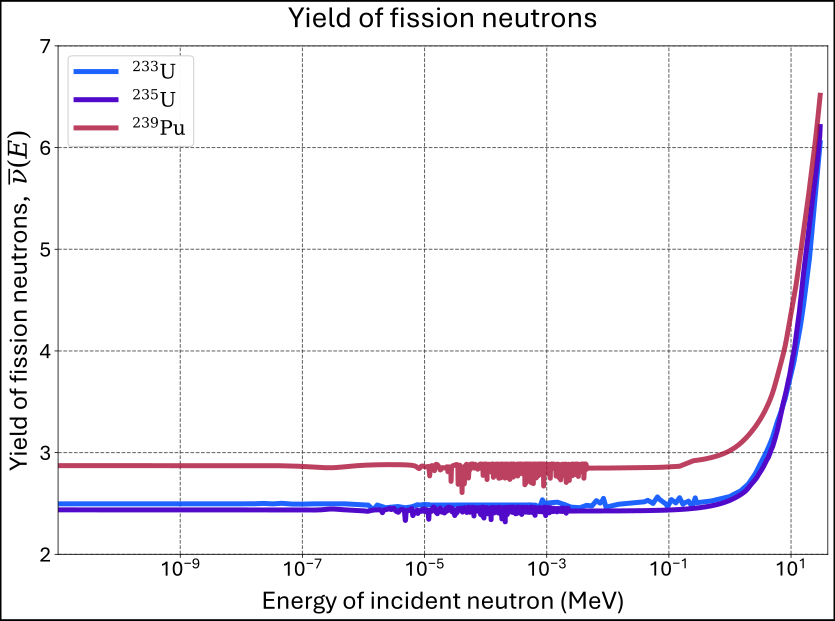

In [15]:
#| echo: true
#| label: fig-yield-fission-neutrons-mainfuel-loge
#| fig-cap: 'Average total fission neutron yield for the principal fuel isotopes - logarithmic energy scale'
#| freeze: true

fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True)
#
x = vec_eng_yield_fn_u233
y = vec_yield_fn_u233
axes.plot(x, y, label=r'$\mathrm{^{233}U}$',
          color=color_u233, linestyle=ls1, linewidth=lw1, marker=None, alpha=0.9)
#
x = vec_eng_yield_fn_u235
y = vec_yield_fn_u235
axes.plot(x, y, label=r'$\mathrm{^{235}U}$',
          color=color_u235, linestyle=ls1, linewidth=lw1, marker=None)
#
x = vec_eng_yield_fn_pu239
y = vec_yield_fn_pu239
axes.plot(x, y, label=r'$\mathrm{^{239}Pu}$',
          color=color_pu239, linestyle=ls1, linewidth=lw1, marker=None, alpha=0.8)
#
title            =  'Yield of fission neutrons'
xlabel           =  'Energy of incident neutron (MeV)'
ylabel           =  r'Yield of fission neutrons,  $\overline{\nu}(E)$'
xlims            =  [E_min, 40]
ylims            =  [2, 7]
xscale           = 'log'
yscale           =  'linear'
ncol_legend      =  1
file_name        =  'yield_fn_u233_u235_pu239_logE'
#
add_to_plot(fig, axes, title, xlabel, ylabel, xlims, ylims, xscale, yscale, ncol_legend, file_name)

#### Discussion

The graph @fig-yield-fission-neutrons-mainfuel-loge indicates that the average yield of fission neutrons, $\displaystyle \overline{\nu}_{\mathrm{tot}}$, is largest for Pu-239 and lower for U-233 and U-235.

Alternative reference formats to try if the above doesn't work:
- Figure [-@fig-yield-fission-neutrons-mainfuel-loge]
- See [Figure @fig-yield-fission-neutrons-mainfuel-loge]

#### Next, the same information is displayed on a linear energy axis, to uncover more detail in the high neutron energy region.

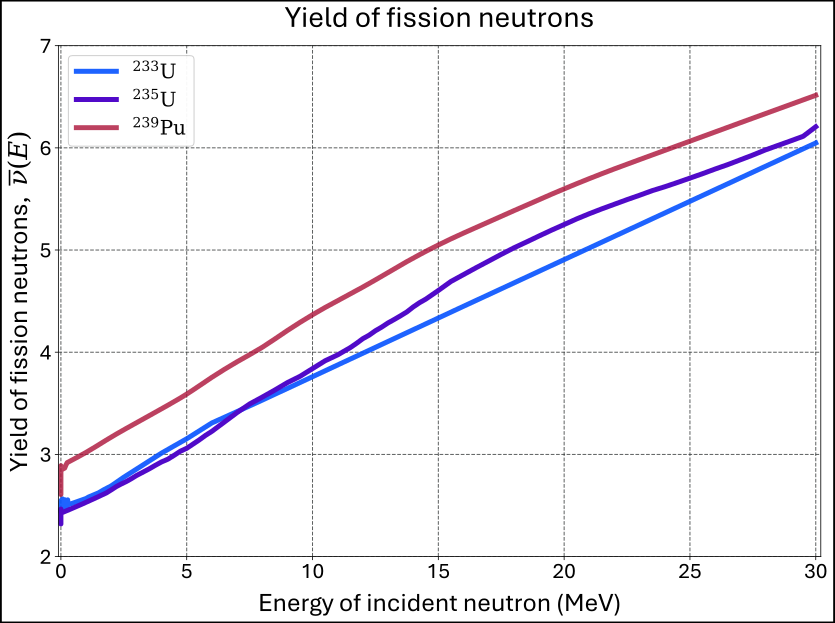

In [16]:
#| echo: true
#| label: fig-yield-fission-neutrons-mainfuel-linE
#| fig-cap: 'Average total fission neutron yield for the fuel isotopes U-233, U-235, and Pu-239 - linear energy scale'

fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True)
#
x = vec_eng_yield_fn_u233
y = vec_yield_fn_u233
axes.plot(x, y, label=r'$\mathrm{^{233}U}$',
          color=color_u233, linestyle=ls1, linewidth=lw1, marker=None, alpha=0.9)
#
x = vec_eng_yield_fn_u235
y = vec_yield_fn_u235
axes.plot(x, y, label=r'$\mathrm{^{235}U}$',
          color=color_u235, linestyle=ls1, linewidth=lw1, marker=None)
#
x = vec_eng_yield_fn_pu239
y = vec_yield_fn_pu239
axes.plot(x, y, label=r'$\mathrm{^{239}Pu}$',
          color=color_pu239, linestyle=ls1, linewidth=lw1, marker=None, alpha=0.8)
#
xlims            =  [-0.1, 30.2]
xscale           =  'linear'
yscale           =  'linear'
file_name        =  'yield_fn_u233_u235_pu239_linE'
#
add_to_plot(fig, axes, title, xlabel, ylabel, xlims, ylims, xscale, yscale, ncol_legend, file_name)

### Average total fission neutron yield $\displaystyle \overline{Y}\left(E\right) = \overline{\nu}\left(E\right)$ for fissionable isotopes of uranium

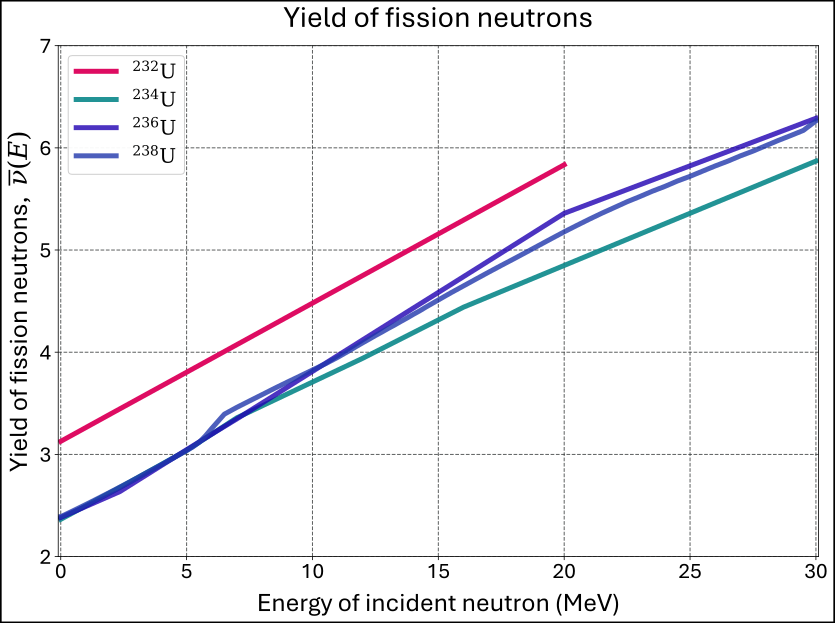

In [17]:
#| echo: true
#| label: fig-yield-fission-neutrons-fissionable-uranium-linE
#| fig-cap: 'Average total fission neutron yield for fissionable isotopes of uranium'

fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True)
#
x = vec_eng_yield_fn_u232
y = vec_yield_fn_u232
axes.plot(x, y, label=r'$\mathrm{^{232}U}$',
          color=color_u232, linestyle=ls1, linewidth=lw1, marker=None)
#
x = vec_eng_yield_fn_u234
y = vec_yield_fn_u234
axes.plot(x, y, label=r'$\mathrm{^{234}U}$',
          color=color_u234, linestyle=ls1, linewidth=lw1, marker=None, alpha=0.9)
#
x = vec_eng_yield_fn_u236
y = vec_yield_fn_u236
axes.plot(x, y, label=r'$\mathrm{^{236}U}$',
          color=color_u236, linestyle=ls1, linewidth=lw1, marker=None, alpha=0.8)
#
x = vec_eng_yield_fn_u238
y = vec_yield_fn_u238
axes.plot(x, y, label=r'$\mathrm{^{238}U}$',
          color=color_u238, linestyle=ls1, linewidth=lw1, marker=None, alpha=0.8)
#
xlims            =  [-0.1, 30.1]
ylims            =  [2, 7]
xscale           =  'linear'
yscale           =  'linear'
file_name        =  'yield_fn_u232_u234_u236_u238_logE'
add_to_plot(fig, axes, title, xlabel, ylabel, xlims, ylims, xscale, yscale, ncol_legend, file_name)

### Average total fission neutron yield $\displaystyle \overline{Y}\left(E\right) = \overline{\nu}\left(E\right)$, for two isotopes of plutonium

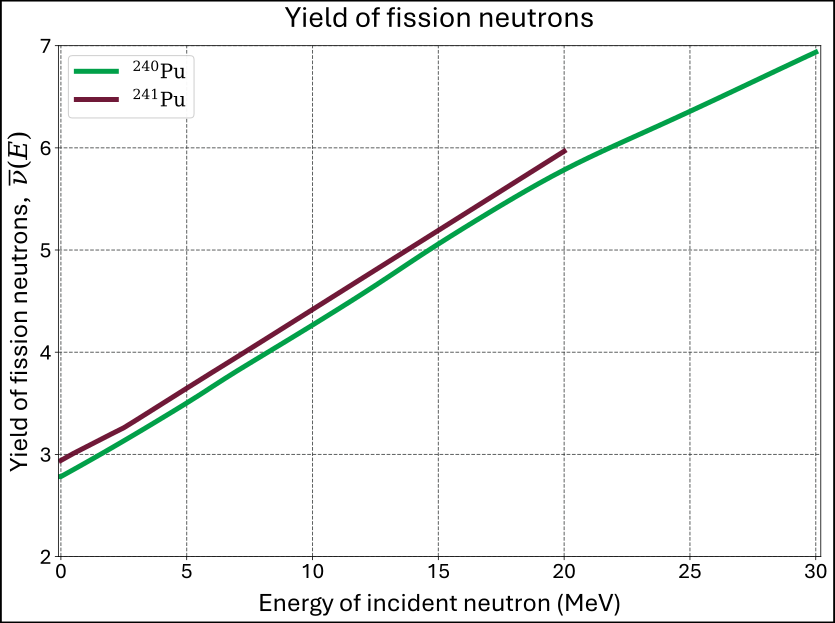

In [18]:
#| echo: true
#| label: fig-yield-fission-neutrons-fissionable-plutonium-linE
#| fig-cap: 'Average total yield of fission neutrons, for fissionable isotopes of plutonium'

fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True)
#
x = vec_eng_yield_fn_pu240
y = vec_yield_fn_pu240
axes.plot(x, y, label=r'$\mathrm{^{240}Pu}$',
          color=color_pu240, linestyle=ls1, linewidth=lw1, marker=None)
#
x = vec_eng_yield_fn_pu241
y = vec_yield_fn_pu241
axes.plot(x, y, label=r'$\mathrm{^{241}Pu}$',
          color=color_pu241, linestyle=ls1, linewidth=lw1, marker=None, alpha=0.9)
#
xlims            =  [-0.1, 30.2]
ylims            =  [2, 7.0]
xscale           =  'linear'
yscale           =  'linear'
file_name        =  'yield_fn_pu240_pu241_linE'
#
add_to_plot(fig, axes, title, xlabel, ylabel, xlims, ylims, xscale, yscale, ncol_legend, file_name)

## Interpolation of the neutron spectrum data to construct a continuous function $\displaystyle \varphi_{n}\left(E\right)$ suitable for numerical integration

In [19]:
x = vec_eng_φ
y = vec_φ
ϕ_n = PchipInterpolator(x, y, extrapolate=None)

print(type(x))
print(type(y))
print(type(ϕ_n))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'scipy.interpolate._cubic.PchipInterpolator'>


#### Example of data query

In [20]:
# Testing:
σ = σ_nf_u233

print('σ(1.1E-11) = ', "{:.2e}".format(σ(1.1E-11)), 'barn')
print('σ(1.0E-10) = ', "{:.2e}".format(σ(1.0E-10)), 'barn')
print('σ(1.0E-09) = ', "{:.2e}".format(σ(1.0E-09)), 'barn')
print('σ(1.0E-08) = ', "{:.2e}".format(σ(1.0E-08)), 'barn')
print('σ(1.0E-07) = ', "{:.2e}".format(σ(1.0E-07)), 'barn')
print('σ(1.0E-06) = ', "{:.2e}".format(σ(1.0E-06)), 'barn')
print('σ(1.0E-05) = ', "{:.2e}".format(σ(1.0E-05)), 'barn')
print('σ(1.0E-04) = ', "{:.2e}".format(σ(1.0E-04)), 'barn')
print('σ(1.0E-03) = ', "{:.2e}".format(σ(1.0E-03)), 'barn')
print('σ(1.0E-02) = ', "{:.2e}".format(σ(1.0E-02)), 'barn')
print('σ(1.0E-01) = ', "{:.2e}".format(σ(1.0E-01)), 'barn')
print('σ(1.00000) = ', "{:.2e}".format(σ(1.00000)), 'barn')
print('σ(2.00000) = ', "{:.2e}".format(σ(2.00000)), 'barn')
print('σ(3.00000) = ', "{:.2e}".format(σ(3.00000)), 'barn')
print('σ(4.00000) = ', "{:.2e}".format(σ(4.00000)), 'barn')
print('σ(5.00000) = ', "{:.2e}".format(σ(5.00000)), 'barn')
print('σ(6.00000) = ', "{:.2e}".format(σ(6.00000)), 'barn')
print('σ(7.00000) = ', "{:.2e}".format(σ(7.00000)), 'barn')
print('σ(8.00000) = ', "{:.2e}".format(σ(8.00000)), 'barn')
print('σ(9.00000) = ', "{:.2e}".format(σ(9.00000)), 'barn')
print('σ(10.0000) = ', "{:.2e}".format(σ(10.0000)), 'barn')
print('σ(12.0000) = ', "{:.2e}".format(σ(12.0000)), 'barn')
print('σ(19.9000) = ', "{:.2e}".format(σ(19.9000)), 'barn')

σ(1.1E-11) =  2.57e+04 barn
σ(1.0E-10) =  8.52e+03 barn
σ(1.0E-09) =  2.69e+03 barn
σ(1.0E-08) =  8.51e+02 barn
σ(1.0E-07) =  2.61e+02 barn
σ(1.0E-06) =  1.38e+02 barn
σ(1.0E-05) =  1.05e+02 barn
σ(1.0E-04) =  5.37e+01 barn
σ(1.0E-03) =  2.34e+01 barn
σ(1.0E-02) =  3.82e+00 barn
σ(1.0E-01) =  2.22e+00 barn
σ(1.00000) =  1.84e+00 barn
σ(2.00000) =  1.96e+00 barn
σ(3.00000) =  1.85e+00 barn
σ(4.00000) =  1.69e+00 barn
σ(5.00000) =  1.57e+00 barn
σ(6.00000) =  1.64e+00 barn
σ(7.00000) =  2.07e+00 barn
σ(8.00000) =  2.27e+00 barn
σ(9.00000) =  2.29e+00 barn
σ(10.0000) =  2.26e+00 barn
σ(12.0000) =  2.17e+00 barn
σ(19.9000) =  2.29e+00 barn


### Calculation of neutron reproduction factor functions

### The above lambda functions are "shorthand" for the following longer definitions:

In [21]:
def nrf_u232(E):
    return (yield_fn_u232(E) * σ_nf_u232(E)) / (σ_nf_u232(E) + σ_nγ_u232(E))
    
def nrf_u233(E):
    return (yield_fn_u233(E) * σ_nf_u233(E)) / (σ_nf_u233(E) + σ_nγ_u233(E))
    
def nrf_u234(E):
    return (yield_fn_u234(E) * σ_nf_u234(E)) / (σ_nf_u234(E) + σ_nγ_u234(E))

def nrf_u235(E):
    return (yield_fn_u235(E) * σ_nf_u235(E)) / (σ_nf_u235(E) + σ_nγ_u235(E))
    
def nrf_u236(E):
    return (yield_fn_u236(E) * σ_nf_u236(E)) / (σ_nf_u236(E) + σ_nγ_u236(E))

def nrf_u238(E):
    return (yield_fn_u238(E) * σ_nf_u238(E)) / (σ_nf_u238(E) + σ_nγ_u238(E))

def nrf_pu239(E):
    return (yield_fn_pu239(E) * σ_nf_pu239(E)) / (σ_nf_pu239(E) + σ_nγ_pu239(E))

def nrf_pu240(E):
    return (yield_fn_pu240(E) * σ_nf_pu240(E)) / (σ_nf_pu240(E) + σ_nγ_pu240(E))

def nrf_pu241(E):
    return (yield_fn_pu241(E) * σ_nf_pu241(E)) / (σ_nf_pu241(E) + σ_nγ_pu241(E))

## Visualisation of the of neutron reproduction factor functions $\displaystyle \eta \left( E \right)$ for fissile and fissionable actinide isotopes

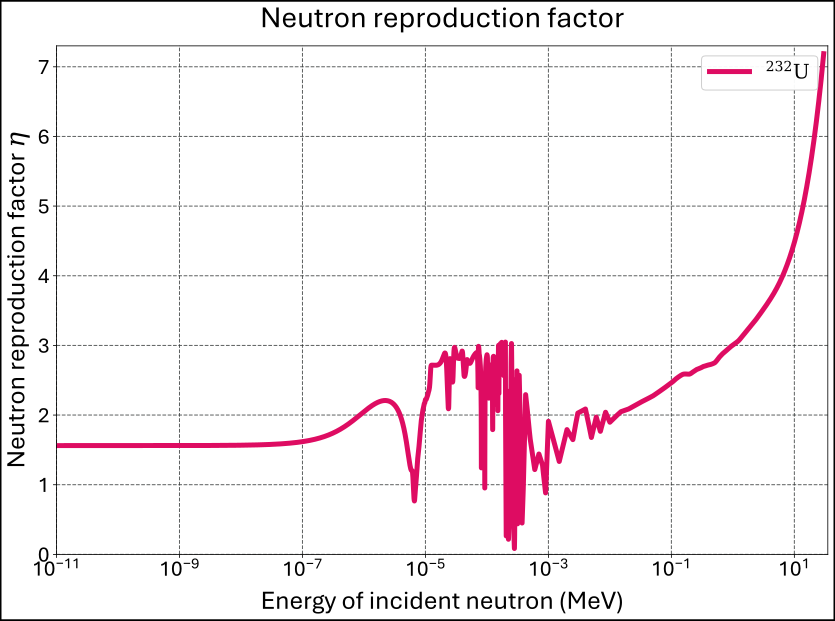

In [22]:
#| echo: true
#| label: fig-nrf-u232
#| fig-cap: 'Neutron reproduction factor for U-232'

fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True)
#
x = E_fine
y = nrf_u232(E_fine)
axes.plot(x, y, label=r'$\mathrm{^{232}U}$', color=color_u232,
          linestyle=ls1, linewidth=lw1, marker=None)
title        =  'Neutron reproduction factor'
ncol_legend  =  1
xlabel       =  'Energy of incident neutron (MeV)'
ylabel       =  r'Neutron reproduction factor $\eta$'
xlims        =  [1E-11, 35]
ylims        =  [0, 7.3]
xscale       =  'log'
yscale       =  'linear'
file_name    =  'nrf_u232_logE'
add_to_plot(fig, axes, title, xlabel, ylabel, xlims, ylims, xscale, yscale, ncol_legend, file_name)

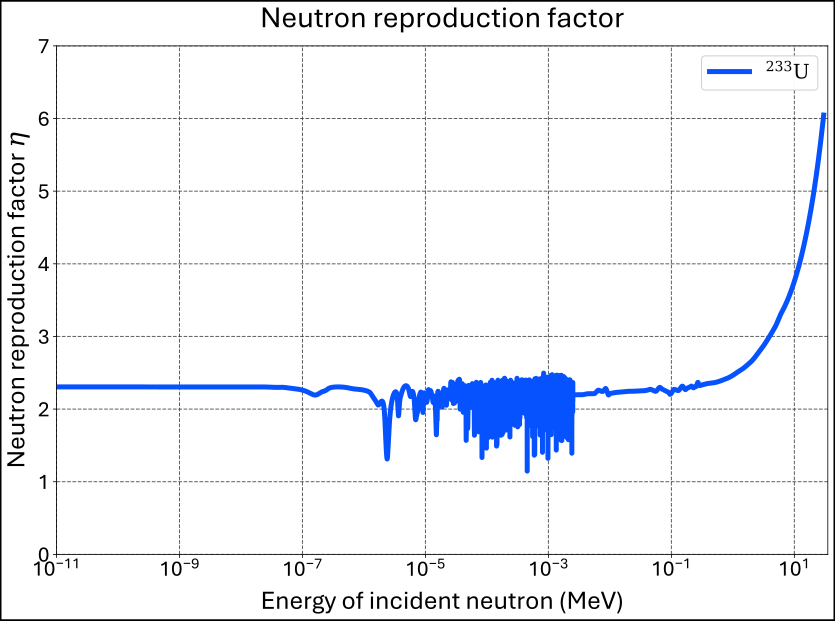

In [23]:
#| echo: true
#| label: fig-nrf_u233
#| fig-cap: 'Neutron reproduction factor for U-233'

x = E_fine
y = nrf_u233(E_fine)
fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True)
axes.plot(x, y, label=r'$\mathrm{^{233}U}$', color=color_u233, linestyle=ls1, linewidth=lw1, marker=None)
xlims      =  [1E-11, 35]
ylims      =  [0, 7]
xscale     =  'log'
yscale     =  'linear'
file_name  =  'nrf_u233_logE'
add_to_plot(fig, axes, title, xlabel, ylabel, xlims, ylims, xscale, yscale, ncol_legend, file_name)

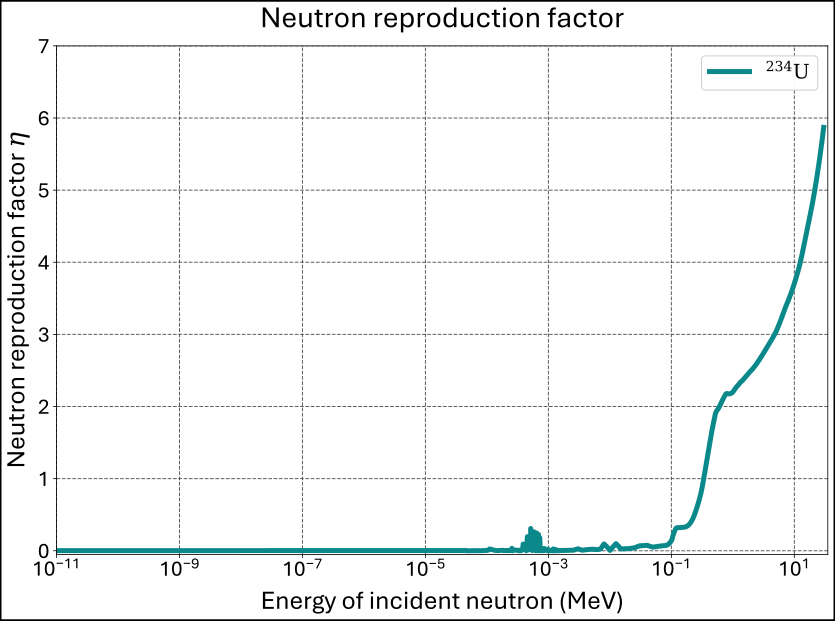

In [24]:
#| echo: true
#| label: fig-nrf-u234
#| fig-cap: 'Neutron reproduction factor for U-234'

x = E_fine
y = nrf_u234(E_fine)
fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True)
axes.plot(x, y, label=r'$\mathrm{^{234}U}$', color=color_u234, linestyle=ls1, linewidth=lw1, marker=None)
xlims      =  [1E-11, 35]
ylims      =  [-0.05, 7]
xscale     =  'log'
yscale     =  'linear'
file_name  =  'nrf_u234_logE'
add_to_plot(fig, axes, title, xlabel, ylabel, xlims, ylims, xscale, yscale, ncol_legend, file_name)

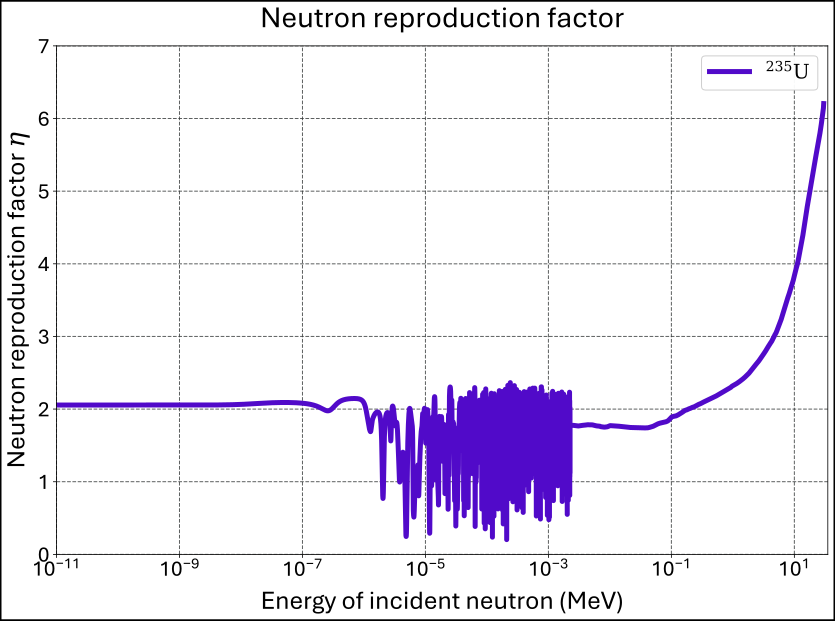

In [25]:
#| echo: true
#| label: fig-nrf-u235
#| fig-cap: 'Neutron reproduction factor for U-235'

x = E_fine
y = nrf_u235(E_fine)
fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True)
axes.plot(x, y, label=r'$\mathrm{^{235}U}$',
          color=color_u235, linestyle=ls1, linewidth=lw1, marker=None)
#
xlims      =  [1E-11, 35]
ylims      =  [0, 7]
xscale     =  'log'
yscale     =  'linear'
file_name  =  'nrf_u235_logE'
#
add_to_plot(fig, axes, title, xlabel, ylabel, xlims, ylims, xscale, yscale, ncol_legend, file_name)

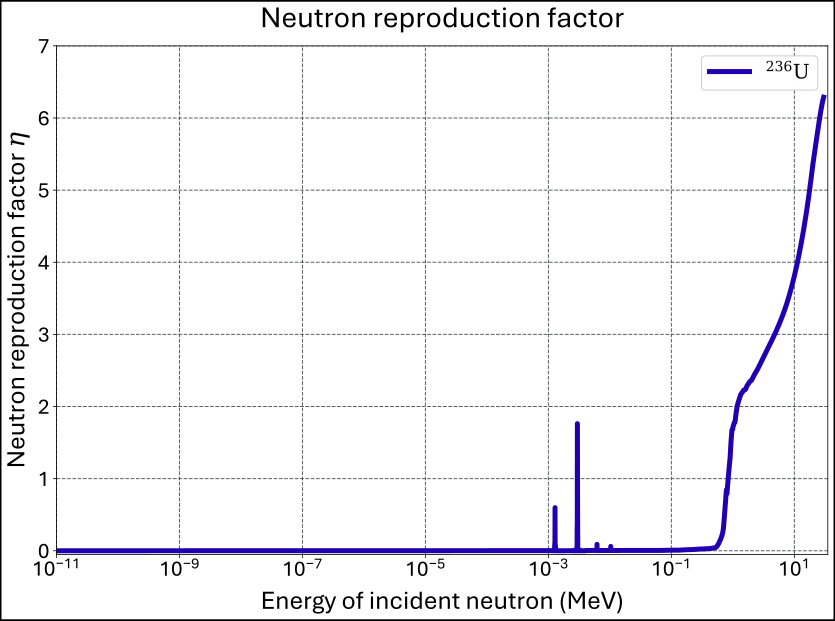

In [26]:
#| echo: true
#| label: fig-nrf-u236
#| fig-cap: 'Neutron reproduction factor for U-236'

x = E_fine
y = nrf_u236(E_fine)
fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True)
axes.plot(x, y, label=r'$\mathrm{^{236}U}$',
          color=color_u236, linestyle=ls1, linewidth=lw1, marker=None)
#
xlims      =  [1E-11, 35]
ylims      =  [-0.05, 7]
xscale     =  'log'
yscale     =  'linear'
file_name  =  'nrf_u236_logE'
#
add_to_plot(fig, axes, title, xlabel, ylabel, xlims, ylims, xscale, yscale, ncol_legend, file_name)

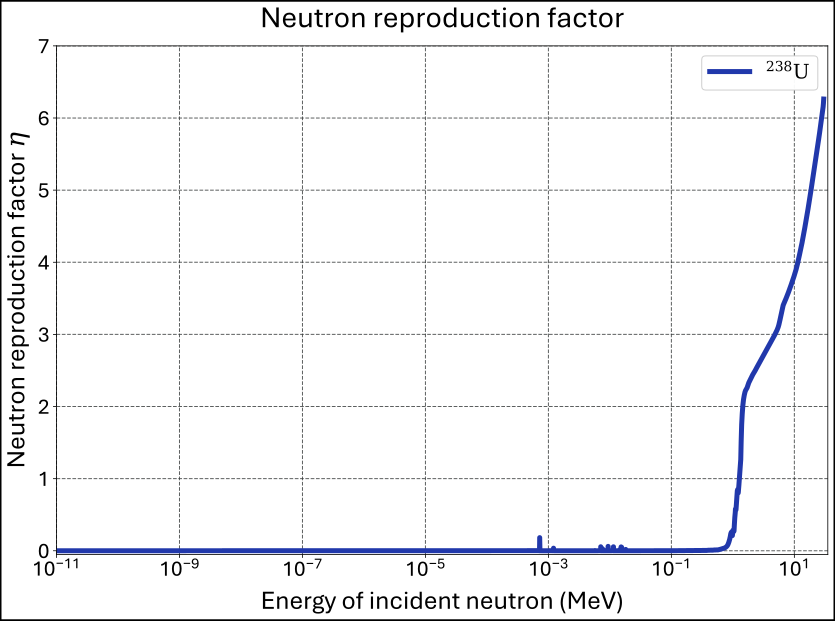

In [27]:
#| echo: true
#| label: fig-nrf-u238
#| fig-cap: 'Neutron reproduction factor for U-238'

x = E_fine
y = nrf_u238(E_fine)
fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True)
axes.plot(x, y, label=r'$\mathrm{^{238}U}$',
          color=color_u238, linestyle=ls1, linewidth=lw1, marker=None)
#
xlims      =  [1E-11, 35]
ylims      =  [-0.05, 7]
file_name  =  'nrf_u238_logE'
#
add_to_plot(fig, axes, title, xlabel, ylabel, xlims, ylims, xscale, yscale, ncol_legend, file_name)

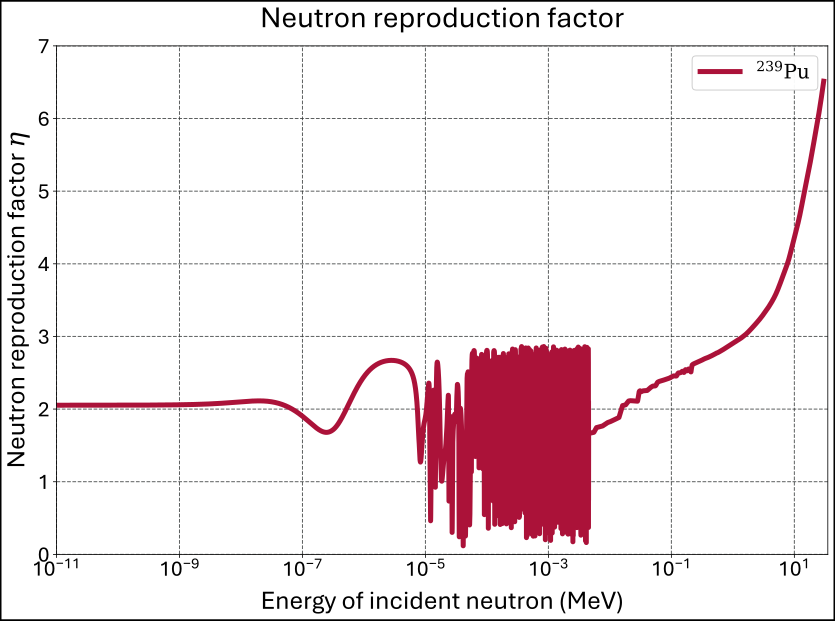

In [28]:
#| echo: true
#| label: fig-nrf_pu239
#| fig-cap: 'Neutron reproduction factor for Pu-239'

x = E_fine
y = nrf_pu239(E_fine)
fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True)
axes.plot(x, y, label=r'$\mathrm{^{239}Pu}$',
          color=color_pu239, linestyle=ls1, linewidth=lw1, marker=None)
#
xlims      =  [1E-11, 35]
ylims      =  [0, 7]
file_name  =  'nrf_pu239_logE'
#
add_to_plot(fig, axes, title, xlabel, ylabel, xlims, ylims, xscale, yscale, ncol_legend, file_name)

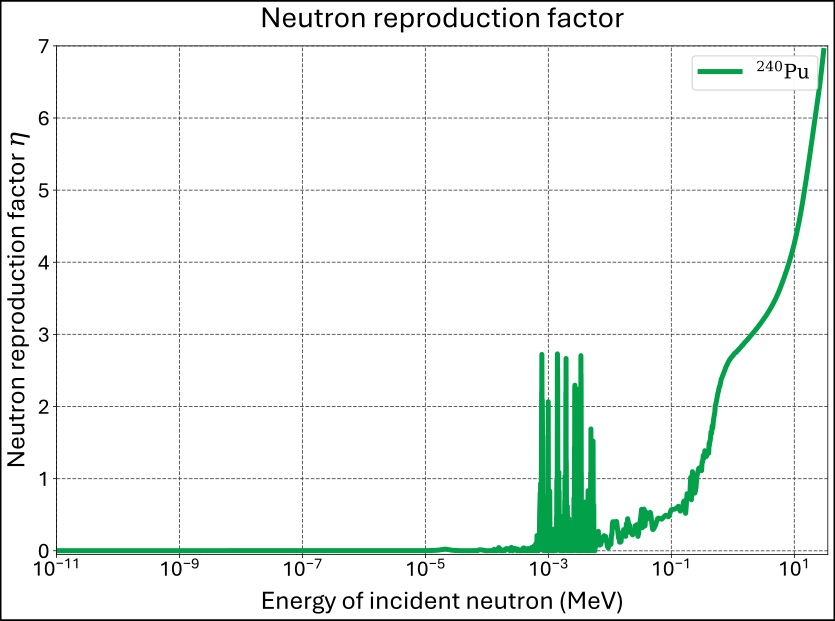

In [29]:
#| echo: true
#| label: fig-nrf-pu240
#| fig-cap: 'Neutron reproduction factor for Pu-240'

x = E_fine
y = nrf_pu240(E_fine)
fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True)
axes.plot(x, y, label=r'$\mathrm{^{240}Pu}$',
          color=color_pu240, linestyle=ls1, linewidth=lw1, marker=None)
#
xlims      =  [1E-11, 35]
ylims      =  [-0.05, 7]
file_name  =  'nrf_pu240_logE'
#
add_to_plot(fig, axes, title, xlabel, ylabel, xlims, ylims, xscale, yscale, ncol_legend, file_name)

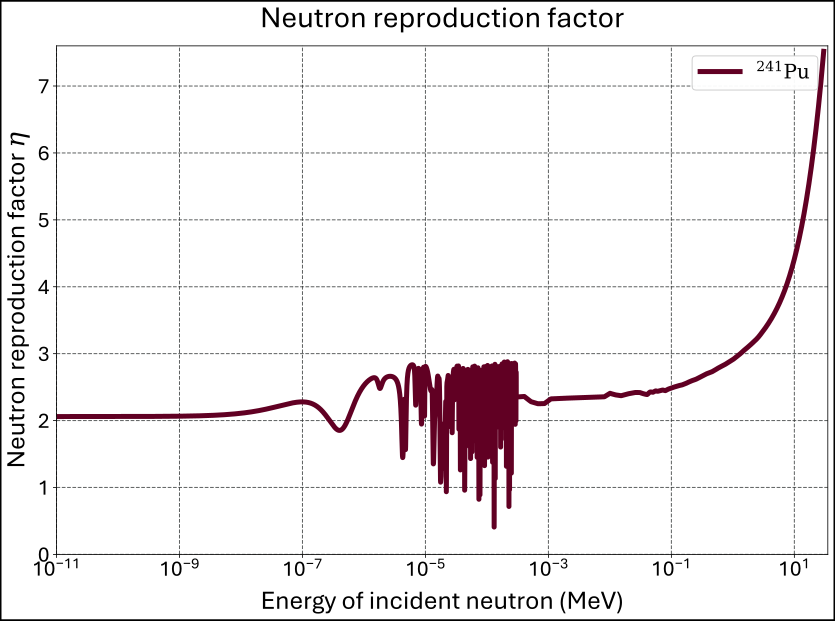

In [30]:
#| echo: true
#| label: fig_nrf_pu241
#| fig-cap: 'Neutron reproduction factor for Pu-241'

x = E_fine
y = nrf_pu241(E_fine)
fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True)
axes.plot(x, y, label=r'$\mathrm{^{241}Pu}$',
          color=color_pu241, linestyle=ls1, linewidth=lw1, marker=None)
xlims      =  [1E-11, 35]
ylims      =  [0, 7.6]
file_name  =  'nrf_pu241_logE'
add_to_plot(fig, axes, title, xlabel, ylabel, xlims, ylims, xscale, yscale, ncol_legend, file_name)

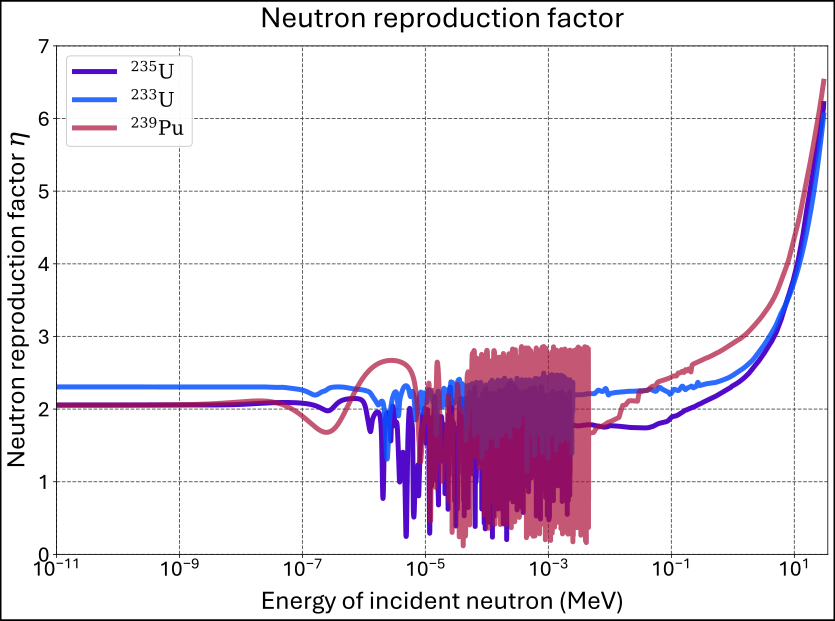

In [31]:
#| echo: true
#| label: fig-nrf-U233-U235-Pu239-logE
#| fig-cap: 'Neutron reproduction factor for the 3 principal fissile actinides: U-233, U-235 and Pu-239 (logarithmic scaling of energy axis)'

fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True)
#
x = E_fine
y = nrf_u235(E_fine)
axes.plot(x, y, label=r'$\mathrm{^{235}U}$',
          color=color_u235, linestyle=ls1, linewidth=lw1, marker=None, alpha=1.00)
#
y = nrf_u233(E_fine)
axes.plot(x, y, label=r'$\mathrm{^{233}U}$',
          color=color_u233, linestyle=ls1, linewidth=lw1, marker=None, alpha=0.85)
#
y = nrf_pu239(E_fine)
axes.plot(x, y, label=r'$\mathrm{^{239}Pu}$',
          color=color_pu239, linestyle=ls1, linewidth=lw1, marker=None, alpha=0.70)
#
xscale     =  'log'
yscale     =  'linear'
xlims      =  [1E-11, 35]
ylims      =  [0, 7]
file_name  =  'nrf_u233_u235_pu239_logE'
add_to_plot(fig, axes, title, xlabel, ylabel, xlims, ylims, xscale, yscale, ncol_legend, file_name)

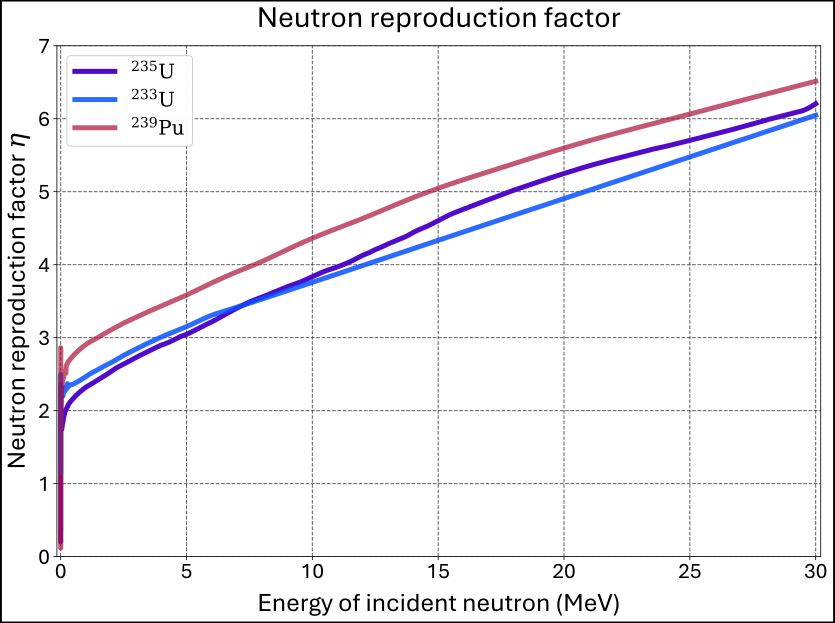

In [32]:
#| echo: true
#| label: fig-nrf-U233-U235-Pu239-linE
#| fig-cap: 'Neutron reproduction factor for the 3 principal fissile actinides: U-233, U-235 and Pu-239 (linear scaling of energy axis)'

fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True)
#
x = E_fine
y = nrf_u235(E_fine)
axes.plot(x, y, label=r'$\mathrm{^{235}U}$',
          color=color_u235, linestyle=ls1, linewidth=lw1, marker=None, alpha=1.00)
#
y = nrf_u233(E_fine)
axes.plot(x, y, label=r'$\mathrm{^{233}U}$',
          color=color_u233, linestyle=ls1, linewidth=lw1, marker=None, alpha=0.85)
#
y = nrf_pu239(E_fine)
axes.plot(x, y, label=r'$\mathrm{^{239}Pu}$',
          color=color_pu239, linestyle=ls1, linewidth=lw1, marker=None, alpha=0.70)
#
xscale = 'linear'
yscale = 'linear'
xlims        =  [-0.15, 30.2]
ylims        =  [0, 7]
file_name    =  'nrf_u233_u235_pu239_linE'
add_to_plot(fig, axes, title, xlabel, ylabel, xlims, ylims, xscale, yscale, ncol_legend, file_name)

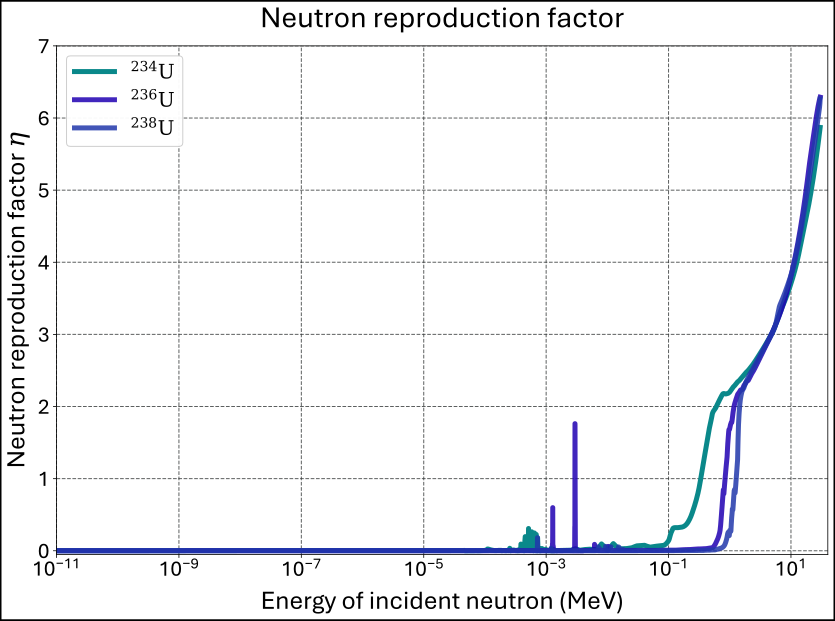

In [33]:
#| echo: true
#| label: fig-nrf-U234-U236-U238
#| fig-cap: 'Neutron reproduction factor for 3 fissionable actinides: U-234, U-236 and U-238'

fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True)
#
x = E_fine
y = nrf_u234(E_fine)
axes.plot(x, y, label=r'$\mathrm{^{234}U}$',
          color=color_u234, linestyle=ls1, linewidth=lw1, marker=None, alpha=1.00)
#
y = nrf_u236(E_fine)
axes.plot(x, y, label=r'$\mathrm{^{236}U}$',
          color=color_u236, linestyle=ls1, linewidth=lw1, marker=None, alpha=0.85)
#
y = nrf_u238(E_fine)
axes.plot(x, y, label=r'$\mathrm{^{238}U}$',
          color=color_u238, linestyle=ls1, linewidth=lw1, marker=None, alpha=0.85)
#
xscale     =  'log'
yscale     =  'linear'
xlims      =  [1E-11, 40]
ylims      =  [-0.05, 7]
file_name  =  'nrf_u234_u236_u238_logE'
add_to_plot(fig, axes, title, xlabel, ylabel, xlims, ylims, xscale, yscale, ncol_legend, file_name)

## Calculate group-averaged neutron reproduction factors $\displaystyle \langle \eta \rangle$, weighed by the selected neutron fluence-rate function

#### If the fluence-weighted neutron reproduction factor, $$\displaystyle \langle \eta \rangle = \frac{\displaystyle \int_{0}^{\infty}\eta\left(E\right)\varphi_{n}\left(E\right)\;dE} {\displaystyle \int_{0}^{\infty}\varphi_{n}\left(E\right)\; dE},$$ is substantially larger than 2.0, the nuclear fuel can, in principle, be gainfully deployed in a breeding reactor.  This metric-of-merit will now be quantified.

## Display the energy-dependent neutron fluence rate $\displaystyle\varphi_{n}\left(E\right)$ inside the reactor fuel, calculated with a reactor analysis code

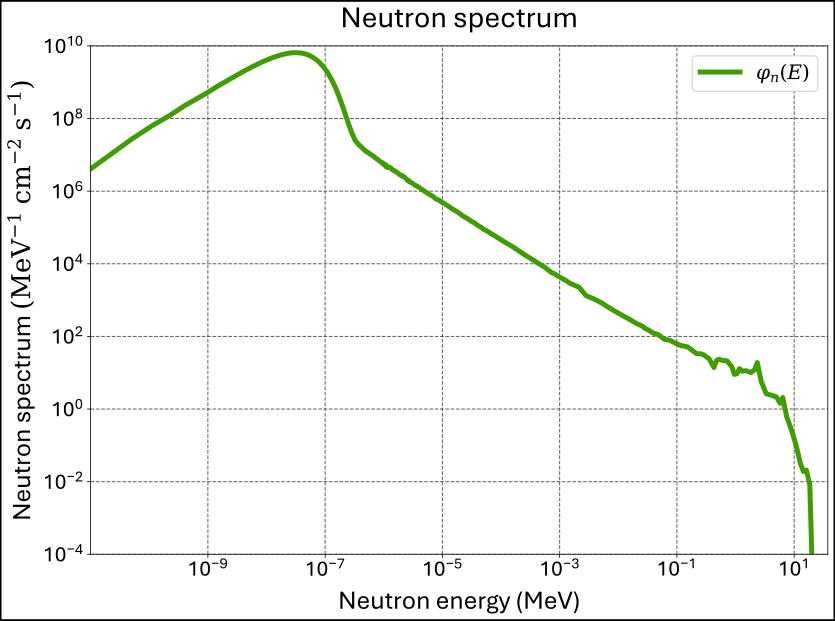

In [34]:
#| echo: true
#| label: fig-neutron-fluence-rate
#| fig-cap: 'Neutron fluence rate in the nuclear reactor for which spectrum-averaged effective neutron reproduction factors are quantified'

fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True)
#
x = vec_eng_φ
y = vec_φ
axes.plot(x, y, label=r'$\varphi_{n}(E)$',
          color=color_n, linestyle=ls1, linewidth=lw1, marker=None)
#
title      =  'Neutron spectrum'
xlabel     =  'Neutron energy (MeV)'
ylabel     =  r'Neutron spectrum $\left(\mathrm{MeV^{-1}\;cm^{-2}\;s^{-1}}\right)$'
xlims      =  [E_min, E_max*1.25]
ylims      =  [1E-4, 1E10]
xscale     =  'log'
yscale     =  'log'
file_name  =  'neutron_fluence_rate_spectrum'
add_to_plot(fig, axes, title, xlabel, ylabel, xlims, ylims, xscale, yscale, ncol_legend, file_name)

## Quantification of the effective, energy-averaged reproduction factors $\displaystyle \langle \eta \rangle$,  in several nuclear fuels, for the selected neutron energy spectrum $\displaystyle\varphi_{n}\left(E\right)$ in the fuel.

#### IF the fluence-weighted neutron reproduction factor, $$\displaystyle \langle \eta \rangle = \frac{\displaystyle \int_{0}^{\infty}\eta\left(E\right)\varphi_{n}\left(E\right)\;dE} {\displaystyle \int_{0}^{\infty}\varphi_{n}\left(E\right)\; dE},$$ is substantially larger than $\displaystyle \langle \eta \rangle=\;$ 2.0, THEN the nuclear fuel can - in principle - be gainfully deployed in a breeding reactor.  This metric-of-merit for the breeding of fissile fuel will now be quantified.

In [35]:
import warnings
warnings.filterwarnings("ignore")

eps_abs = 1.00E-12
eps_rel = 1.00E-12
num_iterations = 999999

In [36]:
fuel_isotope = 'U-232'
nrf_fn = nrf_u232
fraction_top = scipy.integrate.quad(lambda E: nrf_fn(E)*ϕ_n(E), E_min, E_max, epsabs=eps_abs,
                   epsrel=eps_rel, limit=num_iterations)[0]
fraction_bottom =  scipy.integrate.quad(lambda E: ϕ_n(E), E_min, E_max, epsabs=eps_abs,
                   epsrel=eps_rel, limit=num_iterations)[0]
nrf_eff_u232 = fraction_top / fraction_bottom
#
print(f'For pure {fuel_isotope} fuel, the effective neutron reproduction factor is: η({fuel_isotope}) ={nrf_eff_u232:7.3f}')

For pure U-232 fuel, the effective neutron reproduction factor is: η(U-232) =  1.763


In [37]:
fuel_isotope = 'U-233'
nrf_fn = nrf_u233
fraction_top = scipy.integrate.quad(lambda E: nrf_fn(E)*ϕ_n(E), E_min, E_max, epsabs=eps_abs,
                   epsrel=eps_rel, limit=num_iterations)[0]
fraction_bottom =  scipy.integrate.quad(lambda E: ϕ_n(E), E_min, E_max, epsabs=eps_abs,
                   epsrel=eps_rel, limit=num_iterations)[0]
nrf_eff_u233 = fraction_top / fraction_bottom
#
print(f'For pure {fuel_isotope} fuel, the effective neutron reproduction factor is: η({fuel_isotope}) ={nrf_eff_u233:7.3f}')

For pure U-233 fuel, the effective neutron reproduction factor is: η(U-233) =  2.302


In [38]:
fuel_isotope = 'U-234'
nrf_fn = nrf_u234
fraction_top = scipy.integrate.quad(lambda E: nrf_fn(E)*ϕ_n(E), E_min, E_max, epsabs=eps_abs,
                   epsrel=eps_rel, limit=num_iterations)[0]
fraction_bottom =  scipy.integrate.quad(lambda E: ϕ_n(E), E_min, E_max, epsabs=eps_abs,
                   epsrel=eps_rel, limit=num_iterations)[0]
nrf_eff_u234 = fraction_top / fraction_bottom
#
print(f'For pure {fuel_isotope} fuel, the effective neutron reproduction factor is: η({fuel_isotope}) ={nrf_eff_u234:7.3f}')

For pure U-234 fuel, the effective neutron reproduction factor is: η(U-234) =  0.170


In [39]:
fuel_isotope = 'U-235'
nrf_fn = nrf_u235
fraction_top = scipy.integrate.quad(lambda E: nrf_fn(E)*ϕ_n(E), E_min, E_max, epsabs=eps_abs,
                   epsrel=eps_rel, limit=num_iterations)[0]
fraction_bottom =  scipy.integrate.quad(lambda E: ϕ_n(E), E_min, E_max, epsabs=eps_abs,
                   epsrel=eps_rel, limit=num_iterations)[0]
nrf_eff_u235 = fraction_top / fraction_bottom
#
print(f'For pure {fuel_isotope} fuel, the effective neutron reproduction factor is: η({fuel_isotope}) ={nrf_eff_u235:7.3f}')

For pure U-235 fuel, the effective neutron reproduction factor is: η(U-235) =  0.308


In [40]:
fuel_isotope = 'U-236'
nrf_fn = nrf_u236
fraction_top = scipy.integrate.quad(lambda E: nrf_fn(E)*ϕ_n(E), E_min, E_max, epsabs=eps_abs,
                   epsrel=eps_rel, limit=num_iterations)[0]
fraction_bottom =  scipy.integrate.quad(lambda E: ϕ_n(E), E_min, E_max, epsabs=eps_abs,
                   epsrel=eps_rel, limit=num_iterations)[0]
nrf_eff_u236 = fraction_top / fraction_bottom
#
print(f'For pure {fuel_isotope} fuel, the effective neutron reproduction factor is: η({fuel_isotope}) ={nrf_eff_u236:7.3f}')

For pure U-236 fuel, the effective neutron reproduction factor is: η(U-236) =  0.128


In [41]:
fuel_isotope = 'U-238'
nrf_fn = nrf_u238
fraction_top    =  scipy.integrate.quad(lambda E: nrf_fn(E)*ϕ_n(E), E_min, E_max, epsabs=eps_abs,
                   epsrel=eps_rel, limit=num_iterations)[0]
fraction_bottom =  scipy.integrate.quad(lambda E: ϕ_n(E), E_min, E_max, epsabs=eps_abs,
                   epsrel=eps_rel, limit=num_iterations)[0]
nrf_eff_u238    =  fraction_top / fraction_bottom
#
print(f'For pure {fuel_isotope} fuel, the effective neutron reproduction factor is: η({fuel_isotope}) ={nrf_eff_u238:7.3f}')

For pure U-238 fuel, the effective neutron reproduction factor is: η(U-238) =  0.114


In [42]:
fuel_isotope = 'Pu-239'
nrf_fn = nrf_pu239
fraction_top = scipy.integrate.quad(lambda E: nrf_fn(E)*ϕ_n(E), E_min, E_max, epsabs=eps_abs,
                   epsrel=eps_rel, limit=num_iterations)[0]
fraction_bottom =  scipy.integrate.quad(lambda E: ϕ_n(E), E_min, E_max, epsabs=eps_abs,
                   epsrel=eps_rel, limit=num_iterations)[0]
nrf_eff_pu239 = fraction_top / fraction_bottom
print(f'For pure {fuel_isotope} fuel, the effective neutron reproduction factor is: η({fuel_isotope}) ={nrf_eff_pu239:7.3f}')

For pure Pu-239 fuel, the effective neutron reproduction factor is: η(Pu-239) =  2.094


In [43]:
fuel_isotope = 'Pu-240'
nrf_fn = nrf_pu240
fraction_top = scipy.integrate.quad(lambda E: nrf_fn(E)*ϕ_n(E), E_min, E_max, epsabs=eps_abs,
                   epsrel=eps_rel, limit=num_iterations)[0]
fraction_bottom =  scipy.integrate.quad(lambda E: ϕ_n(E), E_min, E_max, epsabs=eps_abs,
                   epsrel=eps_rel, limit=num_iterations)[0]
nrf_eff_pu240 = fraction_top / fraction_bottom
print(f'For pure {fuel_isotope} fuel, the effective neutron reproduction factor is: η({fuel_isotope}) ={nrf_eff_pu240:7.3f}')

For pure Pu-240 fuel, the effective neutron reproduction factor is: η(Pu-240) =  0.211


In [44]:
fuel_isotope = 'Pu-241'
formatted_float = 0.0
nrf_fn = nrf_pu241
fraction_top = scipy.integrate.quad(lambda E: nrf_fn(E)*ϕ_n(E), E_min, E_max, epsabs=eps_abs,
                   epsrel=eps_rel, limit=num_iterations)[0]
fraction_bottom =  scipy.integrate.quad(lambda E: ϕ_n(E), E_min, E_max, epsabs=eps_abs,
                   epsrel=eps_rel, limit=num_iterations)[0]
nrf_eff_pu241 = fraction_top / fraction_bottom
print(f'For pure {fuel_isotope} fuel, the effective neutron reproduction factor is: η({fuel_isotope}) ={nrf_eff_pu241:7.3f}')

For pure Pu-241 fuel, the effective neutron reproduction factor is: η(Pu-241) =  2.298


#### **Table: Effective neutron reproduction factors for selected fuel types for a specified reactor**

| Nuclide |  Neutron reproduction factor:  $\mathrm{\eta_{eff}}$  |
|---|:---|
| $^{232}\mathrm{U}$| `{python} f"{nrf_eff_u232: 10.4f}"` |
| $^{233}\mathrm{U}$| `{python} f"{nrf_eff_u233: 10.4f}"` |
| $^{234}\mathrm{U}$| `{python} f"{nrf_eff_u234: 10.4f}"` |
| $^{235}\mathrm{U}$| `{python} f"{nrf_eff_u235: 10.4f}"` |
| $^{236}\mathrm{U}$| `{python} f"{nrf_eff_u236: 10.4f}"` |
| $^{238}\mathrm{U}$| `{python} f"{nrf_eff_u238: 10.4f}"` |
| $^{239}\mathrm{Pu}$| `{python} f"{nrf_eff_pu239: 10.4f}"` |
| $^{240}\mathrm{Pu}$| `{python} f"{nrf_eff_pu240: 10.4f}"` |
| $^{241}\mathrm{Pu}$| `{python} f"{nrf_eff_pu241: 10.4f}"` |

## Conclusions
*  $\displaystyle ^{233}\text{U}$ fuel is the principal candidate nuclear fuel for a breeder reactor designed to operate with a thermalised neutron spectrum.   <p>&nbsp;</p>
*  $\displaystyle ^{235}\text{U}$ and LEU fuel in general, has a lower neutron reproduction factor, compared to $\displaystyle ^{233}\text{U}$ and $\displaystyle ^{239}\text{Pu}$ fuel.  <p>&nbsp;</p>
*  Pu-239 is the principal nuclear fuel candidate for a fast-spectrum breeder reactor.   <p>&nbsp;</p>
 
#### Additional facts
*  A major issue with U-233 fuel is the high dose rate around fuel assemblies, caused by the inevitable presence of U-232 which forms the highly photon-emissive radionuclide $\displaystyle ^{208}\text{Tl}$.   <p>&nbsp;</p>
*  The delayed neutron fractions of $\displaystyle ^{233}\text{U}$ and $\displaystyle ^{239}\text{Pu}$ are notably lower than that of LEU fuel, which can make reactor control more challenging because the operational bandwidth of the domain of delayed supercriticality between (1) exact criticality and (2) prompt supercriticality, is smaller.